# COGS 108 - Final Project
- Amir Assad (A12721216)
- Danny Chan (A12458661)

## Introduction and Background

In [1]:
# Imports
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

/Users/DannyChan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Description

### 1. Mass Shootings 2015 
* Link: http://www.gunviolencearchive.org/reports/mass-shootings/2015?page=1
* Number of observations: 173
* Description: 

### 2. NICS monthly figures on background checks for gun buyers
* Link: https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view
* Link: https://github.com/BuzzFeedNews/2017-11-gun-sales-estimates/blob/master/data/nics-firearm-background-checks.csv
* Number of observations: 12541
* Description:

### 3. Murders by State, Types of Weapon, 2015 in US
* Link: https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-20/table_20_murder_by_state_types_of_weapons_2015.xls/@@template-layout-view?override-view=data-declaration
* Number of observations: 53
* Description:

## Data Cleaning/Pre-processing

In [2]:
# Import the data from files into Dataframes
df_shootings = pd.read_csv(open('shootings.csv'))
df_background_checks = pd.read_csv(open('nics-firearm-background-checks.csv'))
murder_by_state_by_weapon = pd.read_csv(open("murderByStateByWeapon.csv"))

### Dataset 1

In [3]:
df_shootings.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,"December 31, 2015",Louisiana,New Orleans,1900 block of Amelia Street,0,6,NaN
1,"December 27, 2015",Tennessee,Jackson,North Parkway,0,4,NaN
2,"December 26, 2015",Pennsylvania,Philadelphia,4210 Macalester St,0,4,NaN
3,"December 25, 2015",Florida,Jacksonville,Franklin and Odessa,0,4,NaN
4,"December 25, 2015",Alabama,Mobile,785 Schillinger Rd S,0,4,NaN


In [4]:
incident_count = {}
affected_count = {}
for i, row in df_shootings.iterrows():
    if row['State'] in incident_count:
        incident_count[row['State']] += 1
    else:
        incident_count[row['State']] = 1
        
    if row['State'] in affected_count:
        affected_count[row['State']] += (int(row['# Killed']) + int(row['# Injured']))
    else:
        affected_count[row['State']] = (int(row['# Killed']) + int(row['# Injured']))

In [5]:
df_incident = pd.DataFrame([incident_count]).transpose()
df_affected = pd.DataFrame([affected_count]).transpose()
df_incident.columns = ['# Incident']
df_affected.columns = ['# Affected']

### Dataset 2

In [6]:
def extract_year (input):
    return int(input.split('-')[0])

df_background_checks['year'] = df_background_checks['month'].apply(extract_year)

In [7]:
def create_bg_dataframe(df, year, column):
    temp_df = df[df['year'] == year]
    state_count = {}
    for i, row in temp_df.iterrows():
        if row['state'] in state_count:
            state_count[row['state']] += int(row[column])
        else:
            state_count[row['state']] = int(row[column])
    new_df = pd.DataFrame([state_count])
    new_df = new_df.transpose()
    return new_df

In [8]:
df_2015_total = create_bg_dataframe(df_background_checks, 2015, 'totals')
df_2015_total.columns = ['total_background_checks']
df_2015_total_sorted = df_2015_total.sort_values('total_background_checks')[::-1]

In [9]:
df_2015_handgun = create_bg_dataframe(df_background_checks, 2015, 'handgun')
df_2015_handgun_sorted = df_2015_handgun.sort_values(0)[::-1]

In [10]:
df_2006_2015 = df_background_checks[df_background_checks['year'] >= 2006]
df_2006_2015 = df_2006_2015[df_background_checks['year'] <= 2015]

/Users/DannyChan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [11]:
year_count_total = {}
year_count_handgun = {}
for i, row in df_2006_2015.iterrows():
    if row['year'] in year_count_total:
        year_count_total[row['year']] += int(row['totals'])
    else:
        year_count_total[row['year']] = int(row['totals'])
    if row['year'] in year_count_handgun:
        year_count_handgun[row['year']] += int(row['handgun'])
    else:
        year_count_handgun[row['year']] = int(row['handgun'])

In [12]:
df_year_total = pd.DataFrame([year_count_total])
df_year_total = df_year_total.transpose()
df_year_total.columns = ['total_count']
print(df_year_total)

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


In [13]:
df_year_handgun = pd.DataFrame([year_count_handgun])
df_year_handgun = df_year_handgun.transpose()
df_year_handgun.columns = ['handgun_count']
print(df_year_handgun)

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


### Dataset 3

In [14]:
gun_types = ['Handguns','Shotguns', 'Rifles']
murder_by_state_by_weapon.set_index('State', inplace=True)
murders_by_state = murder_by_state_by_weapon[gun_types]


In [15]:
temp = []
for index, row in murders_by_state.iterrows():
    total = int(row.Handguns) + int(row.Shotguns) + int(row.Rifles)
    temp.append(total)
murders_by_state['Total murders'] = temp  

In [16]:
murder_by_state_by_weapon_VS_mass_shootings = pd.concat([murders_by_state, df_incident, df_affected], axis=1)
murder_by_state_by_weapon_VS_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings.fillna(0)

## Data Visualization

### Dataset 1

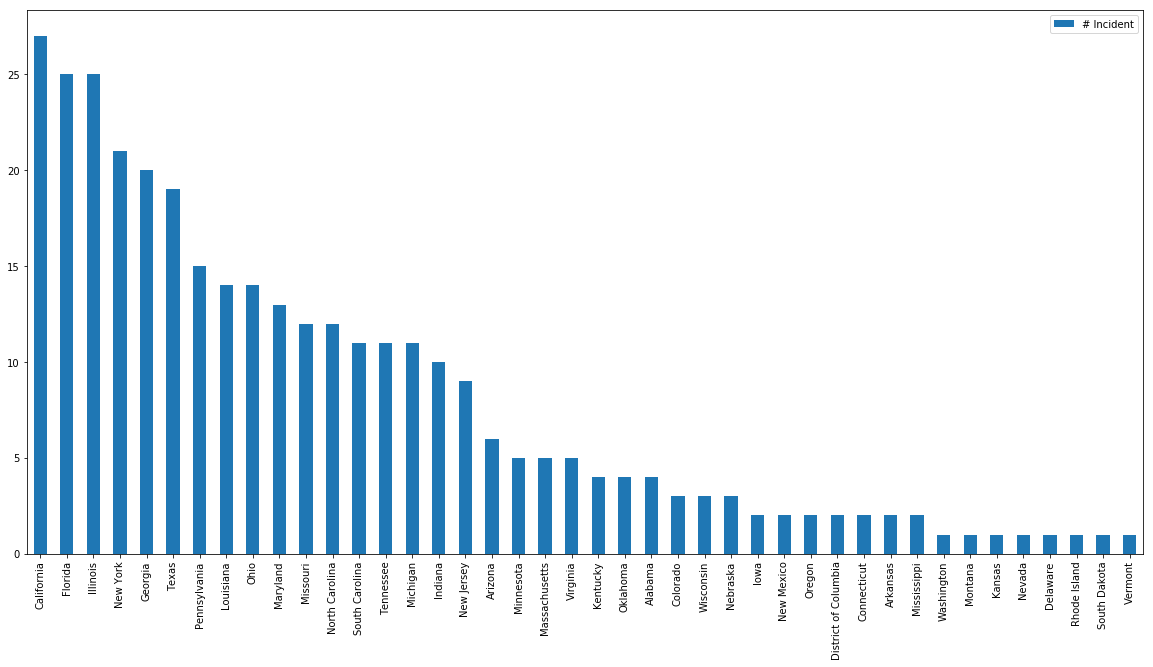

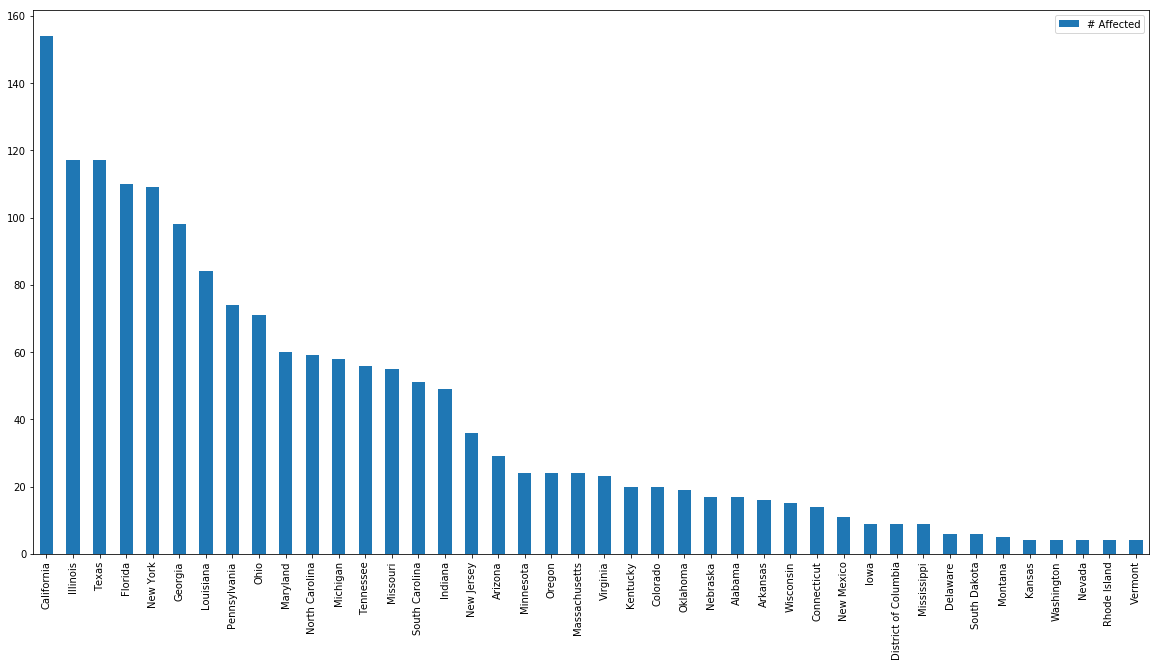

In [17]:
df_incident.sort_values('# Incident')[::-1].plot(kind='bar', figsize=(20,10))
df_affected.sort_values('# Affected')[::-1].plot(kind='bar', figsize=(20,10))

In [18]:
df_shootings_incident_affected = pd.concat([df_incident, df_affected], axis=1)
df_shootings_incident_affected.head()

,# Incident,# Affected
Alabama,4,17
Arizona,6,29
Arkansas,2,16
California,27,154
Colorado,3,20


### Dataset 2

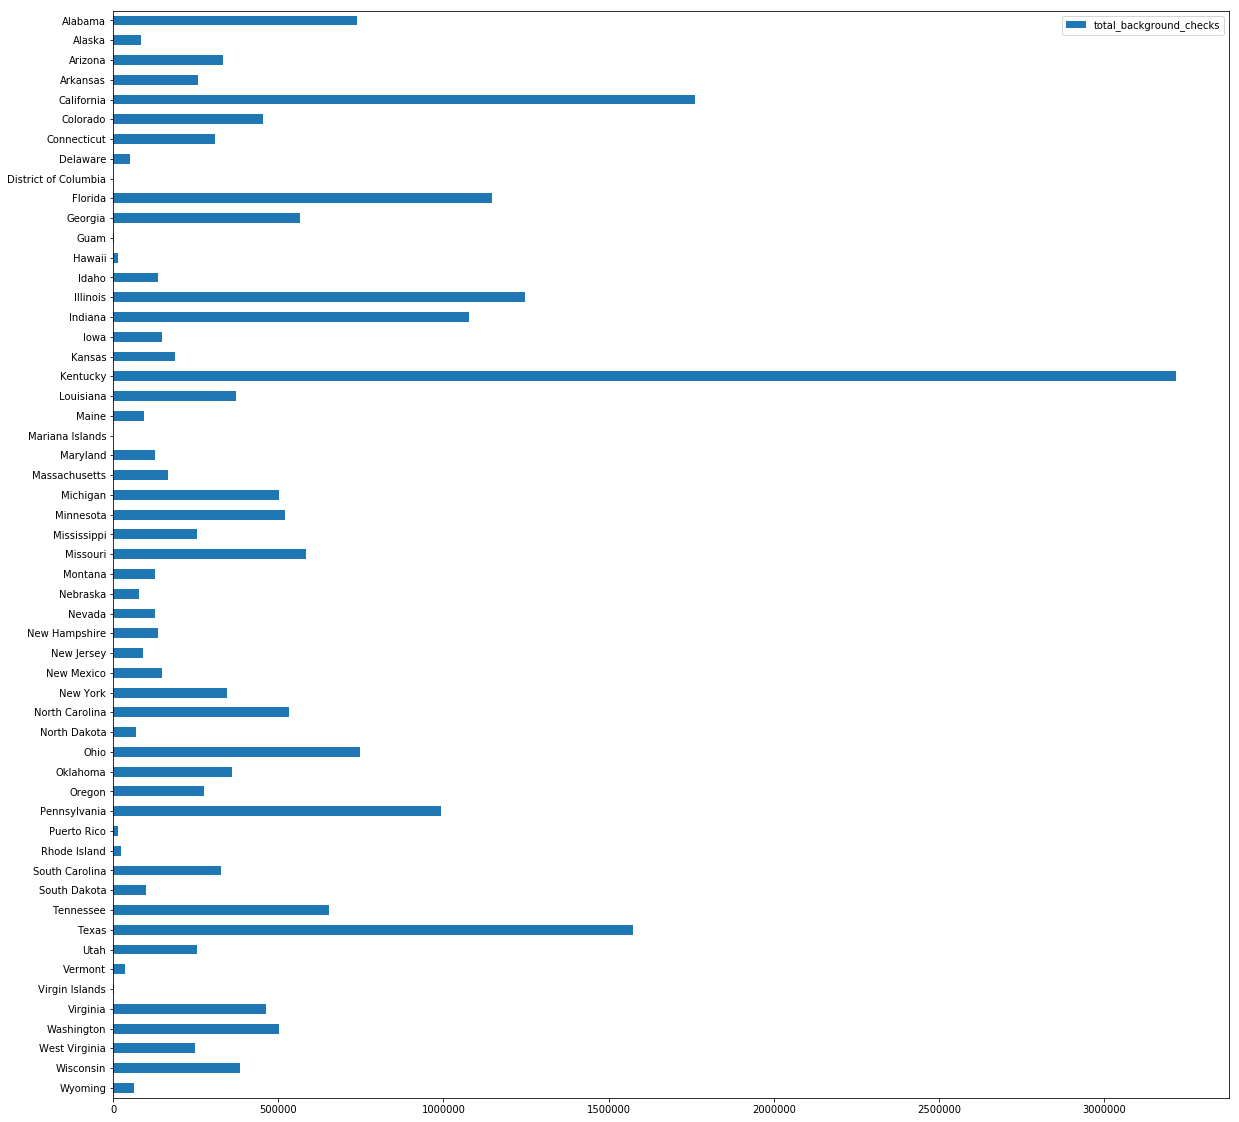

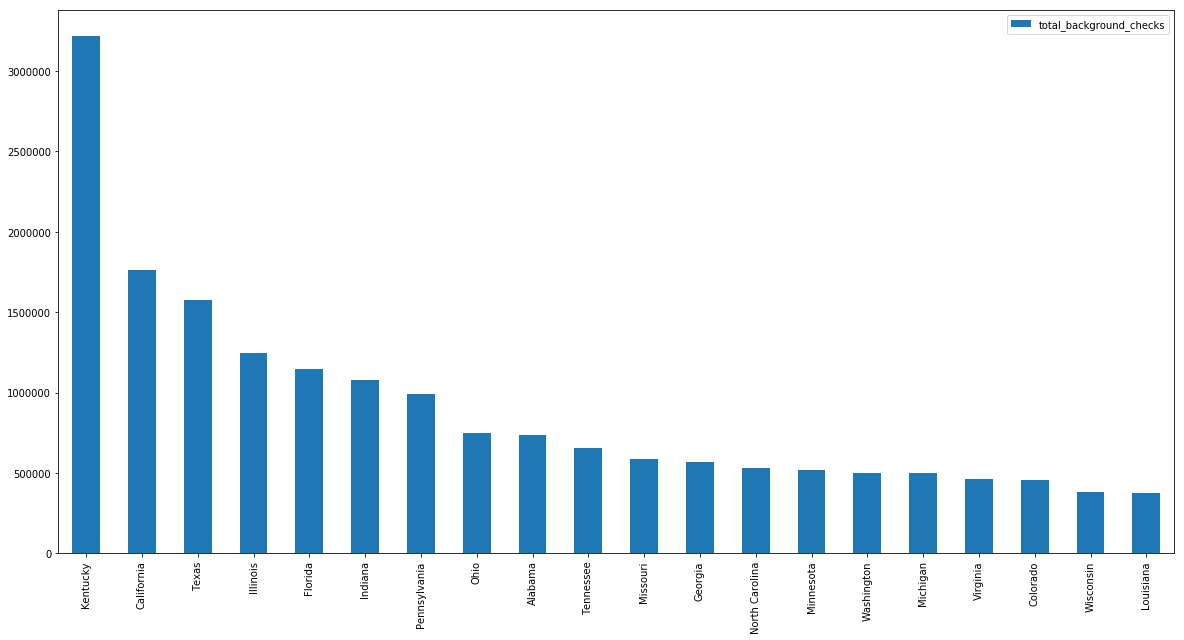

In [19]:
df_2015_total[::-1].plot(kind='barh', figsize=(20,20))
df_2015_total_sorted[:20].plot(kind='bar', figsize=(20,10))

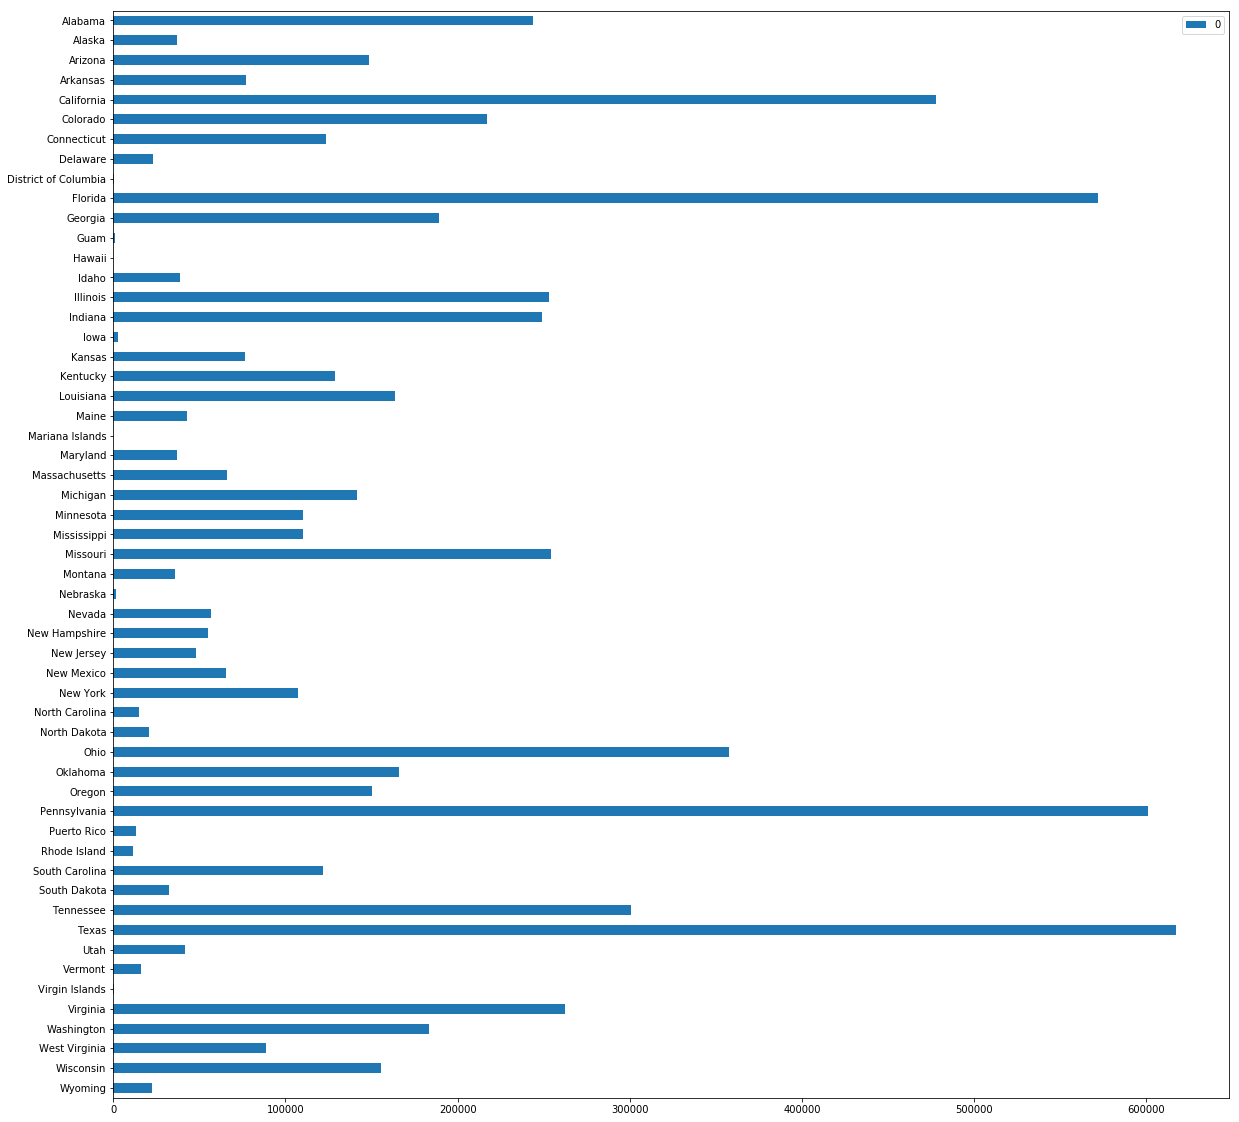

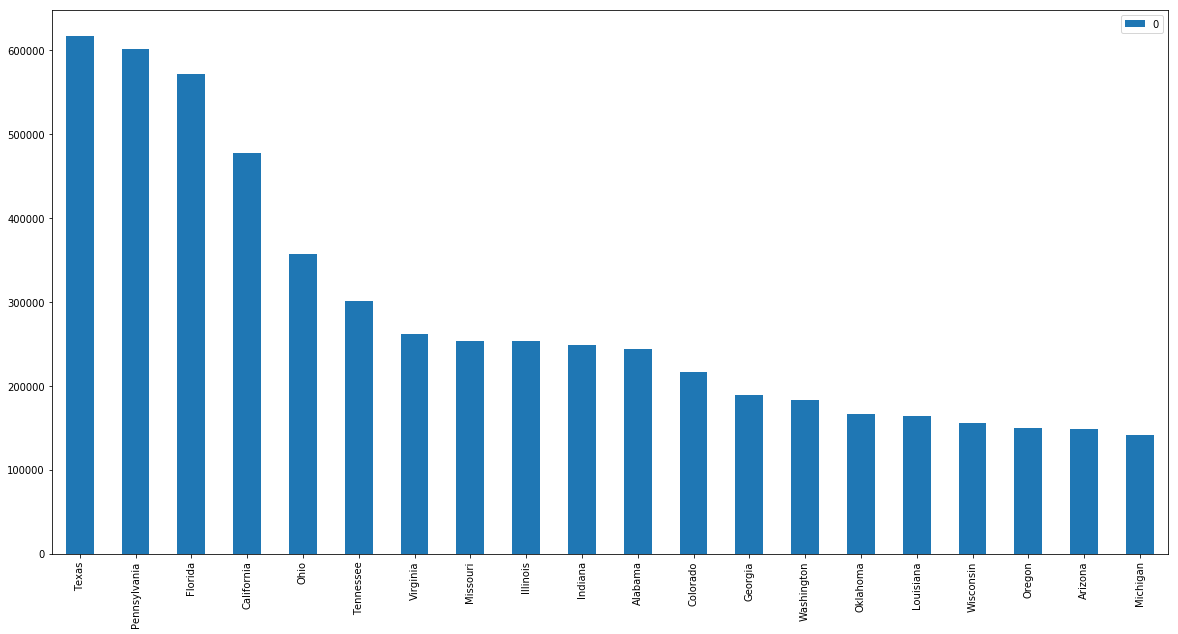

In [20]:
df_2015_handgun[::-1].plot(kind='barh', figsize=(20,20))
df_2015_handgun_sorted[:20].plot(kind='bar', figsize=(20,10))

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


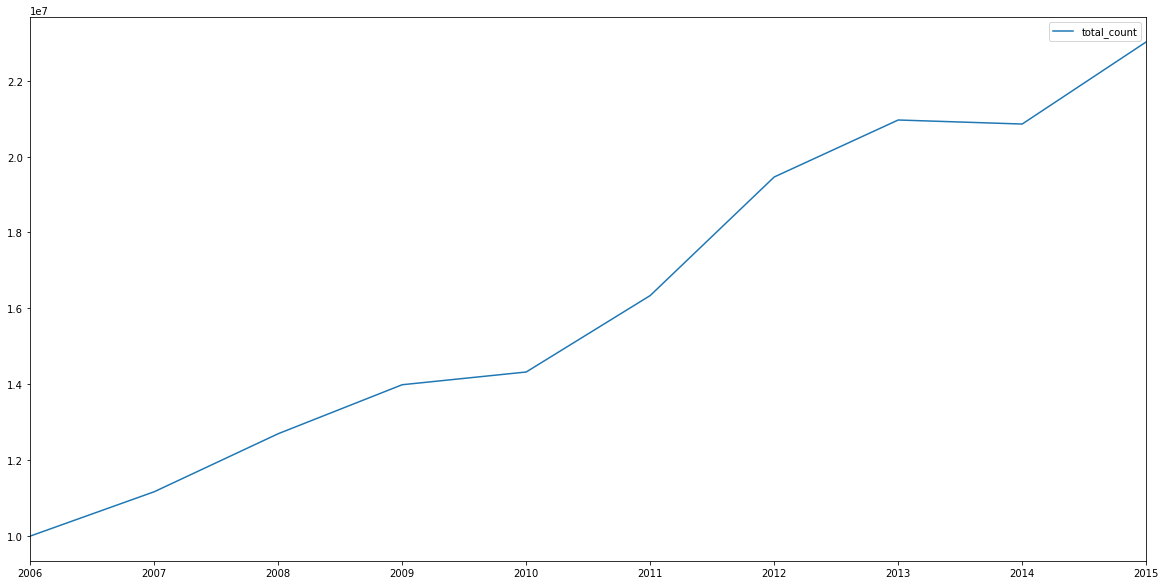

In [21]:
print(df_year_total)
df_year_total.plot(figsize=(20,10))

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


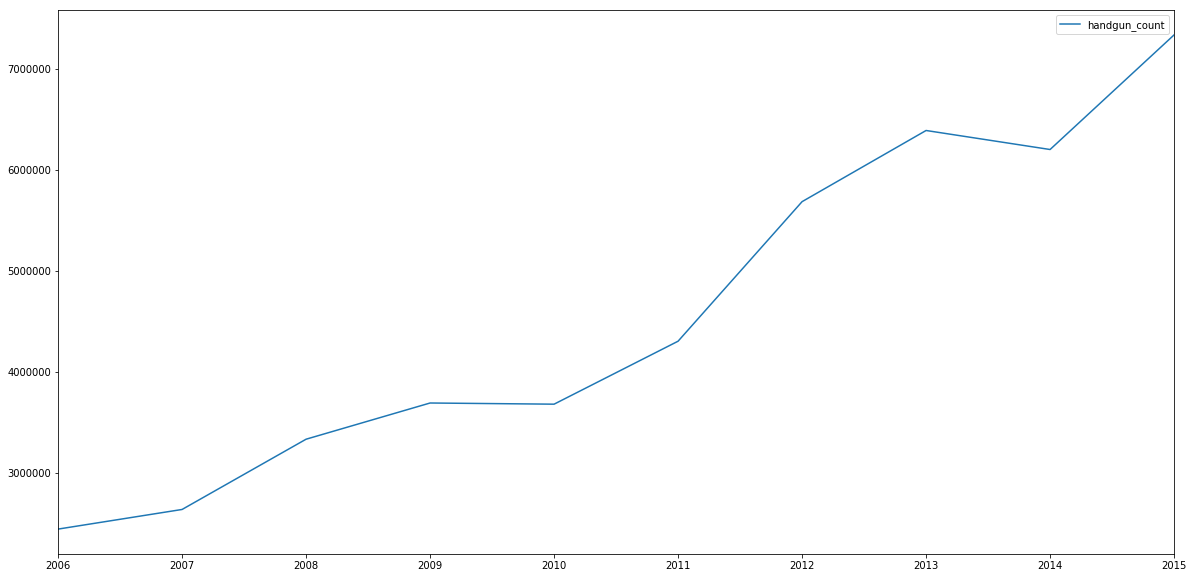

In [22]:
print(df_year_handgun)
df_year_handgun.plot(figsize=(20,10))

### Dataset 3

In [23]:
murders_by_state[gun_types].head()

,Handguns,Shotguns,Rifles
State,,,
Alabama,1,1,0
Alaska,12,1,2
Arizona,128,3,4
Arkansas,51,4,10
California,855,33,34


[Text(0,0.5,'Murders'),
 Text(0.5,0,'State'),
 Text(0.5,1,'Murders per state by weapon')]

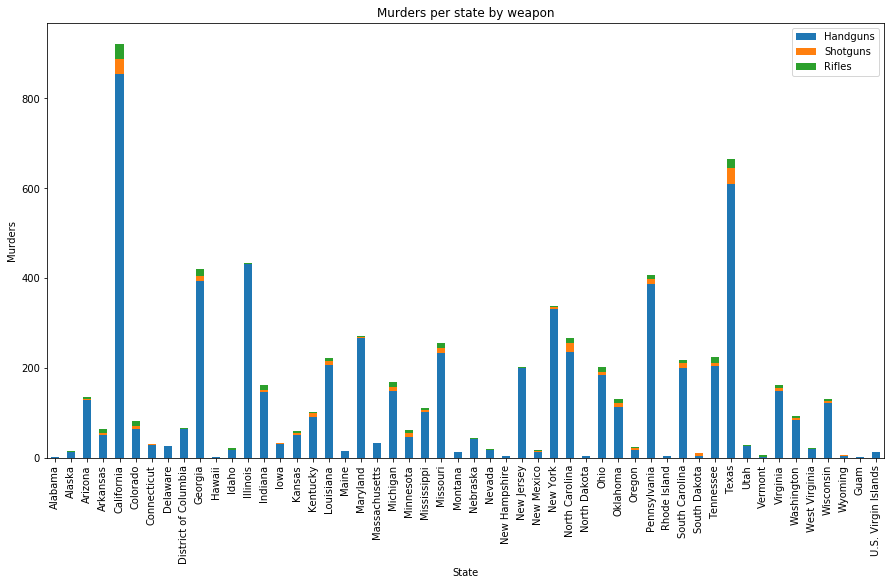

In [24]:
axes = murders_by_state[gun_types].plot.bar(figsize=(15,8), stacked=True)
axes.set(xlabel="State", ylabel="Murders", title="Murders per state by weapon")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1124c6b38>], dtype=object)

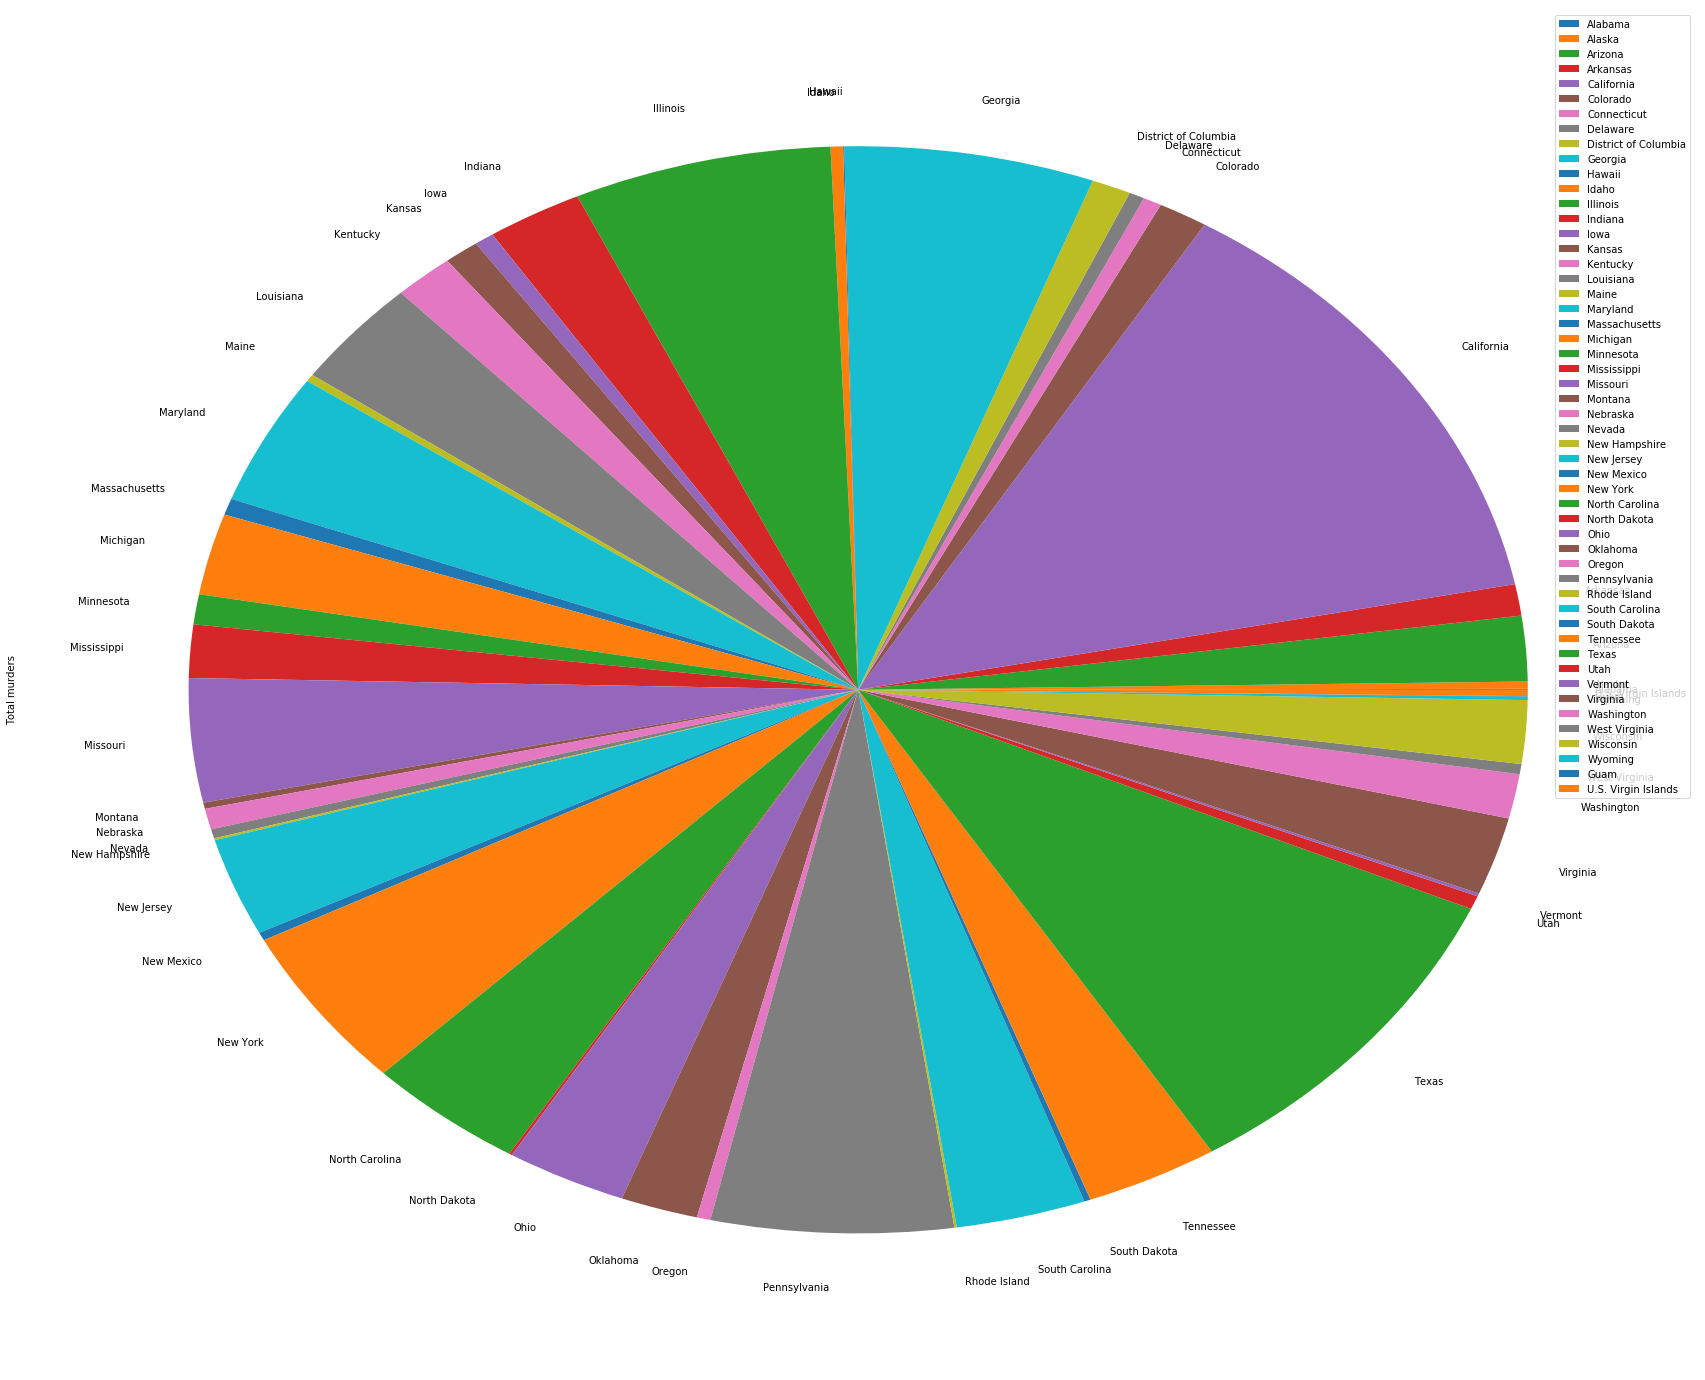

In [25]:
murders_by_state[['Total murders']].plot.pie(subplots=True, figsize=(30, 25))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1664aa20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c23580470>]], dtype=object)

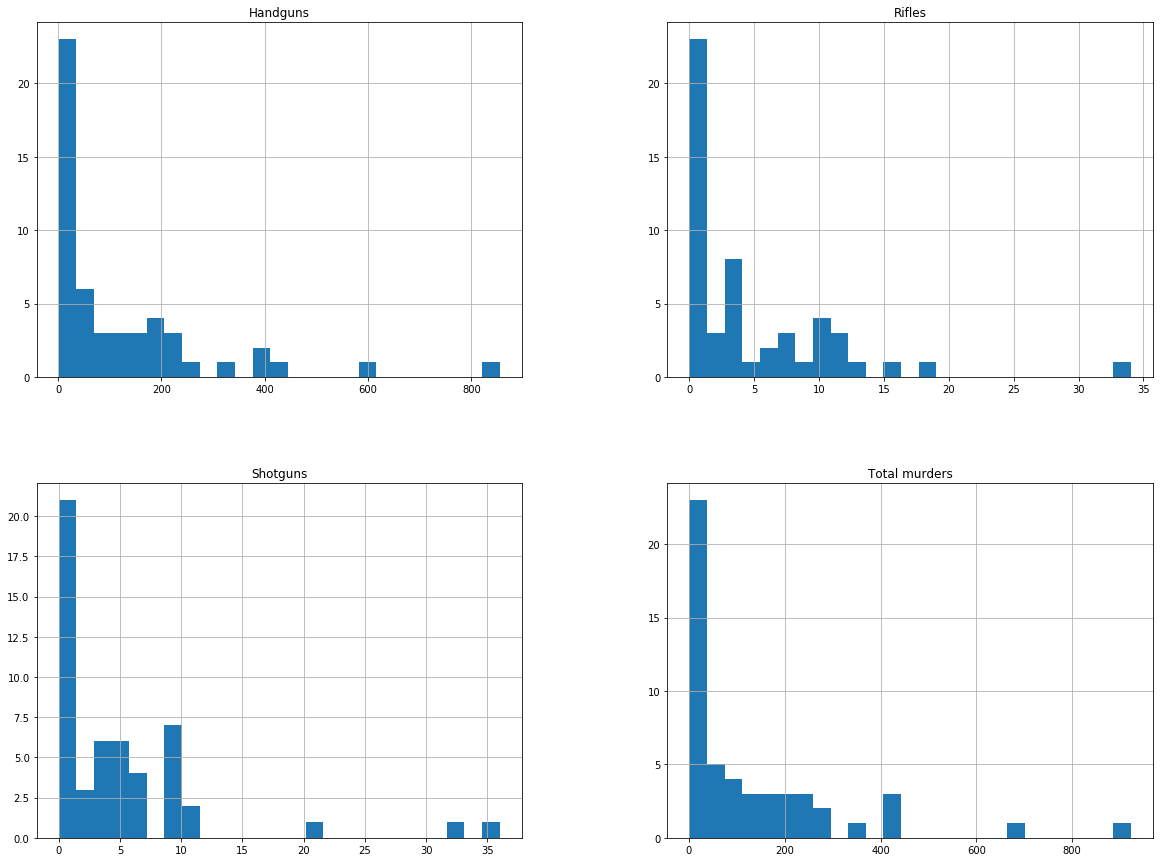

In [26]:
murders_by_state.hist(bins=25, weights=np.ones_like(murders_by_state[murders_by_state.columns[0]]), figsize=(20, 15))

## Data Analysis and Results

### Dataset 2

In [27]:
df_2015_total_merge = pd.concat([df_2015_total, df_incident], axis=1)
df_2015_total_merge.fillna(0, inplace=True)
df_2015_total_merge

,total_background_checks,# Incident
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0
Colorado,454062,3.0
Connecticut,307750,2.0
Delaware,50416,1.0
District of Columbia,742,2.0
Florida,1147082,25.0


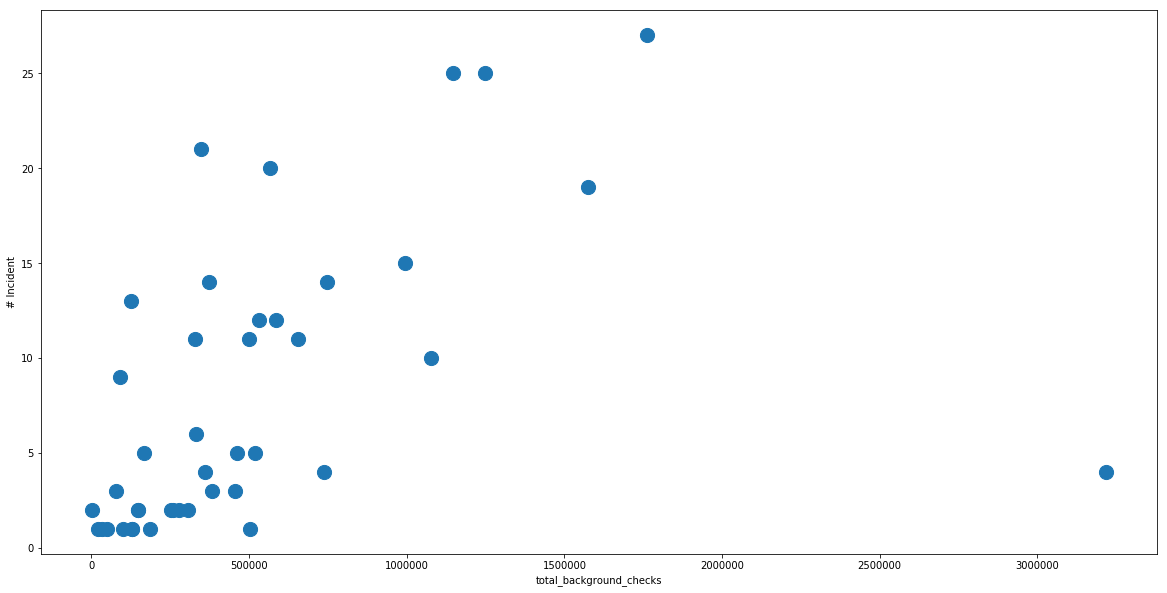

In [28]:
df_2015_total_merge[df_2015_total_merge['# Incident'] > 0].plot(x='total_background_checks', y='# Incident', kind='scatter', figsize=(20,10), s=200)

In [29]:
df_2015_total_merge.columns = ['total', 'incidents']
df_2015_total_merge.head()

,total,incidents
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0


In [30]:
df_2015_clean = df_2015_total_merge[df_2015_total_merge['incidents'] > 0]
out, pred = patsy.dmatrices('incidents ~ total', df_2015_clean)
mod = sm.OLS(out, pred)
res = mod.fit()

In [31]:
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.45
Date:                Sun, 18 Mar 2018   Prob (F-statistic):            0.00161
Time:                        17:26:21   Log-Likelihood:                -139.10
No. Observations:                  42   AIC:                             282.2
Df Residuals:                      40   BIC:                             285.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7702      1.405      3.396      0.0

### Dataset 3

In [32]:
murder_by_state_by_weapon_VS_mass_shootings.head()

,Handguns,Shotguns,Rifles,Total murders,# Incident,# Affected
Alabama,1.0,1.0,0.0,2.0,4.0,17.0
Alaska,12.0,1.0,2.0,15.0,0.0,0.0
Arizona,128.0,3.0,4.0,135.0,6.0,29.0
Arkansas,51.0,4.0,10.0,65.0,2.0,16.0
California,855.0,33.0,34.0,922.0,27.0,154.0


In [33]:
sns.set(rc={'figure.figsize':(20,10)})

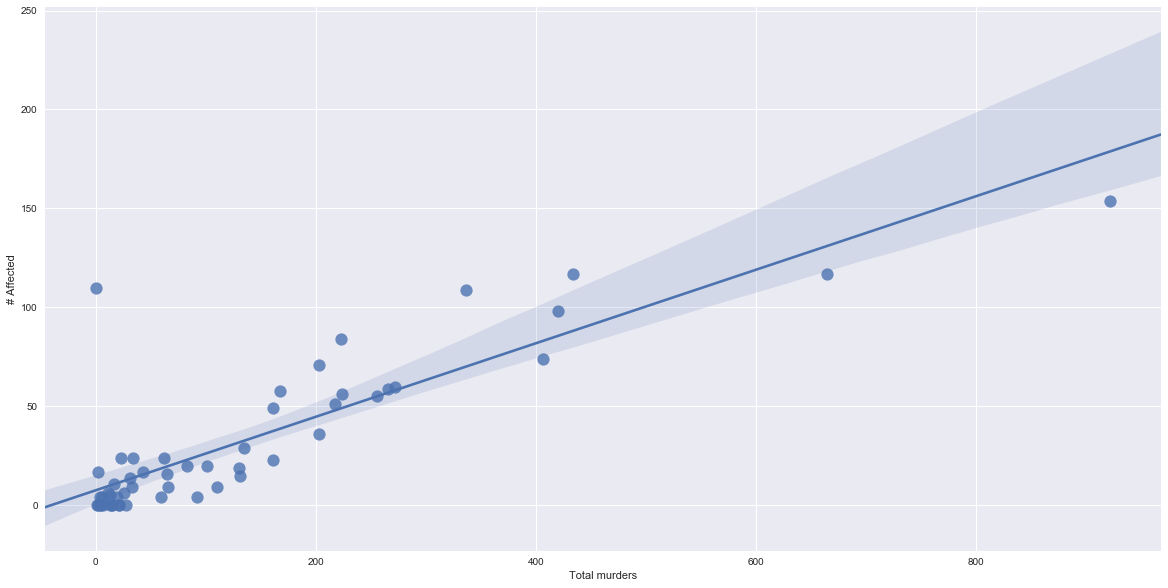

In [34]:
sns.regplot(x='Total murders', y='# Affected', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True,  scatter_kws={'s':150 })

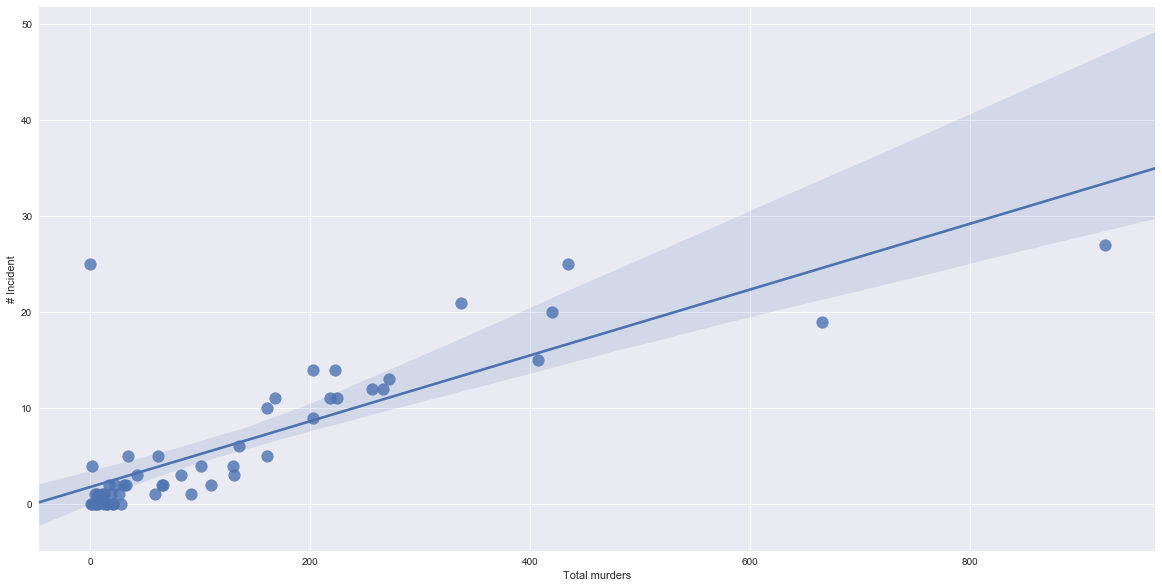

In [35]:
sns.regplot(x='Total murders', y='# Incident', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True, scatter_kws={'s':150 }) 

In [36]:
total_murders_VS_mass_shooting_incidents = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Incident']]
total_murders_VS_people_affected_in_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Affected']]

In [37]:
total_murders_VS_mass_shooting_incidents.columns = ['murders', 'incidents']
total_murders_VS_people_affected_in_mass_shootings.columns = ['murders', 'affected']

In [38]:
total_murders_VS_mass_shooting_incidents.head()

,murders,incidents
Alabama,2.0,4.0
Alaska,15.0,0.0
Arizona,135.0,6.0
Arkansas,65.0,2.0
California,922.0,27.0


In [39]:
out, pred = patsy.dmatrices('incidents ~ murders', total_murders_VS_mass_shooting_incidents)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     101.5
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           1.01e-13
Time:                        17:26:22   Log-Likelihood:                -152.50
No. Observations:                  53   AIC:                             309.0
Df Residuals:                      51   BIC:                             312.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7724      0.750      2.362      0.0

In [40]:
total_murders_VS_people_affected_in_mass_shootings.head()

,murders,affected
Alabama,2.0,17.0
Alaska,15.0,0.0
Arizona,135.0,29.0
Arkansas,65.0,16.0
California,922.0,154.0


In [41]:
out, pred = patsy.dmatrices('affected ~ murders', total_murders_VS_people_affected_in_mass_shootings)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               affected   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     146.3
Date:                Sun, 18 Mar 2018   Prob (F-statistic):           1.34e-16
Time:                        17:26:22   Log-Likelihood:                -232.31
No. Observations:                  53   AIC:                             468.6
Df Residuals:                      51   BIC:                             472.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5677      3.382      2.238      0.0

## Privacy/Ethics Considerations

## Conclusion and Discussion